In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

In [2]:
# Let's load some other image dataset

normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(root='./data', train=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomCrop(32, 4),
        torchvision.transforms.ToTensor(),
        normalize,
    ]), download=True),
    batch_size=128, shuffle=True, num_workers=8)

val_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(root='./data', train=False, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        normalize,
    ])),
    batch_size=128, shuffle=False,
    num_workers=8, pin_memory=True)

for input, target in train_loader:
    print(input.shape, target.shape)
    print(target)
    break

Files already downloaded and verified
torch.Size([128, 3, 32, 32]) torch.Size([128])
tensor([8, 5, 9, 1, 1, 8, 1, 1, 1, 1, 9, 4, 9, 5, 5, 1, 7, 0, 2, 9, 1, 3, 5, 6,
        7, 0, 6, 8, 5, 4, 8, 9, 0, 6, 5, 8, 7, 3, 7, 6, 9, 1, 9, 9, 5, 8, 4, 8,
        0, 3, 4, 6, 3, 3, 6, 9, 5, 8, 7, 6, 0, 9, 9, 7, 5, 6, 0, 3, 0, 7, 1, 1,
        3, 9, 5, 8, 9, 3, 7, 1, 1, 0, 7, 1, 4, 3, 7, 3, 9, 4, 8, 2, 0, 4, 5, 0,
        1, 9, 3, 1, 7, 4, 9, 5, 0, 6, 7, 6, 3, 1, 6, 7, 2, 7, 3, 8, 6, 4, 2, 1,
        9, 4, 0, 8, 4, 2, 4, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


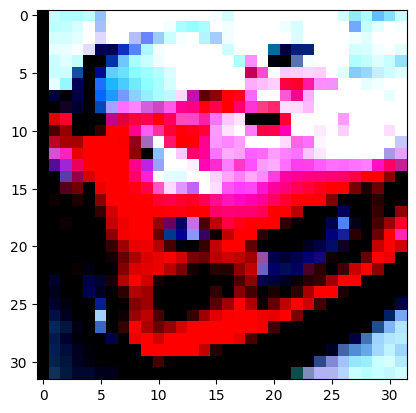

In [3]:
plt.imshow(input[7].permute(1,2,0))

In [4]:
# Basic blocks

class SelfAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super().__init__()
        
        self.q_proj = nn.Linear(embed_size, embed_size, bias=False)
        self.k_proj = nn.Linear(embed_size, embed_size, bias=False)
        self.v_proj = nn.Linear(embed_size, embed_size, bias=False)
        self.o_proj = nn.Linear(embed_size, embed_size, bias=False)
        
        self.num_heads = num_heads
        self.head_size = embed_size // num_heads
        
    def forward(self, x):
        B, L, E = x.shape
        q = self.q_proj(x).reshape(B, L, self.num_heads, self.head_size).transpose(1, 2)
        k = self.k_proj(x).reshape(B, L, self.num_heads, self.head_size).transpose(1, 2)
        v = self.v_proj(x).reshape(B, L, self.num_heads, self.head_size).transpose(1, 2)
        
        # This is what you want to use in practice
        attn_out = F.scaled_dot_product_attention(q, k, v)
        reshaped = attn_out.transpose(1,2).reshape(B, L, E)
        return self.o_proj(reshaped)
            
        
class Block(nn.Module):
    def __init__(self, embed_size, num_heads):
        super().__init__()
        
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        
        self.self_attn = SelfAttention(embed_size, num_heads)
        
        # We also have an MLP block, it's contents differ, LLaMA uses complicated structure, we will
        # keep the simple one
        self.mlp = nn.Sequential(
            nn.Linear(embed_size, 4*embed_size),
            nn.SiLU(),
            nn.Linear(4*embed_size, embed_size)
        )
        
    def forward(self, x):
        # Why do we do self addition and normalization? Next lecture!
        x = x + self.self_attn(self.norm1(x))
        x = x + self.mlp(self.norm1(x))
        return x

In [5]:
# Cut image into 4x4 pieces and turn each one into vector

class Patcher(nn.Module):
    def __init__(self, patch_size, embed_size):
        super().__init__()
        
        self.patch = nn.Conv2d(3, embed_size, patch_size, stride=patch_size)
        
    def forward(self, x):
        patched = self.patch(x)
        # Now we have shape: B, embed_size, H/4, W/4
        return patched.flatten(2).permute(0, 2, 1)
    
Patcher(4, 47)(input).shape

torch.Size([128, 64, 47])

In [6]:
class Model(nn.Module):
    def __init__(self, patch_size, image_shape, embed_size, num_heads, n_blocks, n_classes):
        super().__init__()
        
        self.patcher = Patcher(patch_size, embed_size)
        total_pos_embs = (image_shape // patch_size) ** 2
        
        self.pos_embed = nn.Parameter(torch.randn(total_pos_embs, embed_size))
        
        # This token will gather information about output
        self.class_token = nn.Parameter(torch.rand(embed_size))
        
        self.blocks = nn.Sequential(
            *[Block(embed_size, num_heads) for _ in range(n_blocks)]
        )
        
        self.out_norm = nn.LayerNorm(embed_size)
        self.out = nn.Linear(embed_size, n_classes)
        
    def forward(self, x):
        patched = self.patcher(x) + self.pos_embed
        B = x.shape[0]
        with_cls_token = torch.cat([self.class_token.repeat(B, 1, 1), patched], dim=1)
        
        z = self.blocks(with_cls_token)
        z = self.out_norm(z[:,0])
        return self.out(z)
    
Model(4, 32, 64, 4, 4, 10)(input).shape

torch.Size([128, 10])

In [ ]:
# Let's train
# Usually for small dataset like this you would want Convolutional network, so accuracy here would not be great

model = Model(4, 32, 64, 4, 8, 10)
model.cuda()
opt = torch.optim.AdamW(model.parameters(), 3e-4, weight_decay=1e-4)

def train_epoch():
    loss_sum = 0
    loss_cc = 0
    acc_sum = 0
    acc_cc = 0
    for input, targets in tqdm.tqdm(train_loader):
        out = model(input.cuda())
        loss = nn.CrossEntropyLoss()(out, targets.cuda())
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        loss_sum += loss.item()
        loss_cc += 1
        
        acc_sum += (out.argmax(dim=-1) == targets.cuda()).sum().item()
        acc_cc += targets.numel()
        
    print("train loss", loss_sum / loss_cc, "train acc", acc_sum / acc_cc)
    
@torch.no_grad()
def val_epoch():
    loss_sum = 0
    loss_cc = 0
    acc_sum = 0
    acc_cc = 0
    for input, targets in tqdm.tqdm(val_loader):
        out = model(input.cuda())
        loss = nn.CrossEntropyLoss()(out, targets.cuda())
        
        loss_sum += loss.item()
        loss_cc += 1
        
        acc_sum += (out.argmax(dim=-1) == targets.cuda()).sum().item()
        acc_cc += targets.numel()
        
    print("val loss", loss_sum / loss_cc, "val acc", acc_sum / acc_cc)
    
for epoch in range(50):
    train_epoch()
    val_epoch()

  0%|          | 0/391 [00:00<?, ?it/s]

train loss 1.900852107330966 train acc 0.2898


  0%|          | 0/79 [00:00<?, ?it/s]

val loss 1.7291155133066298 val acc 0.3606


  0%|          | 0/391 [00:00<?, ?it/s]

train loss 1.6358406848614784 train acc 0.39918


  0%|          | 0/79 [00:00<?, ?it/s]

val loss 1.5253909916817388 val acc 0.4492


  0%|          | 0/391 [00:00<?, ?it/s]

train loss 1.511778701906619 train acc 0.44626


  0%|          | 0/79 [00:00<?, ?it/s]

val loss 1.4030157267292844 val acc 0.4921


  0%|          | 0/391 [00:00<?, ?it/s]

train loss 1.4261486173590736 train acc 0.47896


  0%|          | 0/79 [00:00<?, ?it/s]

val loss 1.3471856177607668 val acc 0.5108


  0%|          | 0/391 [00:00<?, ?it/s]

train loss 1.3670128894888836 train acc 0.50368


  0%|          | 0/79 [00:00<?, ?it/s]

val loss 1.2988118114350717 val acc 0.5329


  0%|          | 0/391 [00:00<?, ?it/s]

train loss 1.3226659063183133 train acc 0.51728


  0%|          | 0/79 [00:00<?, ?it/s]

val loss 1.2614819445187533 val acc 0.5402


  0%|          | 0/391 [00:00<?, ?it/s]

train loss 1.2802004564143812 train acc 0.5356


  0%|          | 0/79 [00:00<?, ?it/s]

val loss 1.2230194112922572 val acc 0.5621


  0%|          | 0/391 [00:00<?, ?it/s]

train loss 1.2448157968423557 train acc 0.5504


  0%|          | 0/79 [00:00<?, ?it/s]

val loss 1.2193967119047913 val acc 0.5621


  0%|          | 0/391 [00:00<?, ?it/s]

train loss 1.2148438207328778 train acc 0.55842


  0%|          | 0/79 [00:00<?, ?it/s]

val loss 1.1795146895360342 val acc 0.5733


  0%|          | 0/391 [00:00<?, ?it/s]

train loss 1.1861897155147074 train acc 0.5704


  0%|          | 0/79 [00:00<?, ?it/s]

val loss 1.1313207496570636 val acc 0.5954


  0%|          | 0/391 [00:00<?, ?it/s]

train loss 1.159624283423509 train acc 0.583


  0%|          | 0/79 [00:00<?, ?it/s]

val loss 1.1030517929716954 val acc 0.6076


  0%|          | 0/391 [00:00<?, ?it/s]

train loss 1.1354908769392906 train acc 0.59044


  0%|          | 0/79 [00:00<?, ?it/s]

val loss 1.0746412314946139 val acc 0.6175


  0%|          | 0/391 [00:00<?, ?it/s]

train loss 1.112960575486693 train acc 0.60148


  0%|          | 0/79 [00:00<?, ?it/s]

val loss 1.1012723596790168 val acc 0.608


  0%|          | 0/391 [00:00<?, ?it/s]

train loss 1.0994121385047504 train acc 0.60814


  0%|          | 0/79 [00:00<?, ?it/s]

val loss 1.0562991831876054 val acc 0.6205


  0%|          | 0/391 [00:00<?, ?it/s]

train loss 1.076718688163611 train acc 0.61322


  0%|          | 0/79 [00:00<?, ?it/s]

val loss 1.037733117990856 val acc 0.6341


  0%|          | 0/391 [00:00<?, ?it/s]

train loss 1.0589323772493835 train acc 0.62066


  0%|          | 0/79 [00:00<?, ?it/s]

val loss 1.0303124845782412 val acc 0.6357


  0%|          | 0/391 [00:00<?, ?it/s]

train loss 1.0388504557902245 train acc 0.62888


  0%|          | 0/79 [00:00<?, ?it/s]

val loss 1.0042401333398456 val acc 0.643


  0%|          | 0/391 [00:00<?, ?it/s]

train loss 1.0202625913693166 train acc 0.63454


  0%|          | 0/79 [00:00<?, ?it/s]

val loss 0.9938517280771763 val acc 0.6385


  0%|          | 0/391 [00:00<?, ?it/s]

train loss 1.0079851874610042 train acc 0.64012


  0%|          | 0/79 [00:00<?, ?it/s]

val loss 0.9789777405654327 val acc 0.6493


  0%|          | 0/391 [00:00<?, ?it/s]

train loss 0.9976818547834216 train acc 0.64238


  0%|          | 0/79 [00:00<?, ?it/s]

val loss 0.9821992116638377 val acc 0.648


  0%|          | 0/391 [00:00<?, ?it/s]

train loss 0.9805187691203163 train acc 0.65192


  0%|          | 0/79 [00:00<?, ?it/s]